Knižnice a inicializácia SparkSwssion

In [62]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when, count, mean
from pyspark.sql import functions as F, DataFrame
from pyspark.sql.types import NumericType, IntegerType
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, ChiSqSelector
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from functools import reduce

import matplotlib.pyplot as plt
import pandas as pd
import os

spark = SparkSession.builder.appName("zadanieTSVD").getOrCreate()

Načítanie dát

In [52]:
# header=True –> použije prvý riadok ako názvy stĺpcov
# inferSchema=True –> automaticky určí dátové typy
accidents = spark.read.csv("DATA/Accidents.csv",header=True,inferSchema=True)
casualties = spark.read.csv("DATA/Casualties.csv",header=True,inferSchema=True)
vehicles = spark.read.csv("DATA/Vehicles.csv",header=True,inferSchema=True)

# Exploračná analýza

In [3]:
# Funkcia na základnú exploračnú analýzu dát.
# Parametre:
# df -> PySpark DataFrame na  analýzu
# name -> Názov datasetu (len pre výpis)
def eda_summary(df, name="Dataset"):
    print(f"\n{30*'#'} ANALÝZA {name} {30*'#'}\n")
    # Dátové typy
    print("\nDátové typy:\n")
    for column, dtype in df.dtypes:
        print(f"{column}: {dtype}")
    # Prvý záznam (vertikálne)
    print("\nPrvý záznam (vertikálne):\n")
    df.show(n=1, truncate=True, vertical=True)
    # Schéma datasetu
    print("\nSchéma datasetu:\n")
    df.printSchema()
    # Základné štatistiky
    print("\nZákladné štatistiky:\n")
    df.describe().show(vertical=True)
    # Chýbajúce hodnoty
    print("\nChýbajúce hodnoty v datasetu:\n")
    df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show(vertical=True)
    print(f"\n{30*'#'} KONIEC ANALÝZY {name} {30*'#'}\n")

### Accidents
Accident_Index – Unikátny identifikátor nehody.  
Location_Easting_OSGR, Location_Northing_OSGR – Súradnice v britskom súradnicovom systéme (OSGR).  
Longitude, Latitude – Geografická poloha nehody.  
Police_Force – Kód policajnej jednotky, ktorá nehodu riešila.  
Accident_Severity – Závažnosť nehody (napr. mierna, vážna, smrteľná).  
Number_of_Vehicles – Počet vozidiel zapojených do nehody.  
Number_of_Casualties – Počet zranených/osôb postihnutých nehodou.  
Date, Time – Dátum a čas nehody.  
Day_of_Week – Deň v týždni, kedy k nehode došlo.  
Local_Authority_(District), Local_Authority_(Highway) – Miestne samosprávy zodpovedné za danú lokalitu.  
1st_Road_Class, 2nd_Road_Class – Kategória cesty (napr. diaľnica, hlavná cesta).  
1st_Road_Number, 2nd_Road_Number – Číslo cesty (ak existuje).  
Road_Type – Typ cesty (napr. jednosmerná, kruhový objazd).  
Speed_limit – Maximálna povolená rýchlosť v mieste nehody.  
Junction_Detail, Junction_Control – Informácie o križovatke (napr. semafory, kruhový objazd).  
Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities – Prítomnosť priechodu pre chodcov a jeho typ.  
Light_Conditions – Svetelné podmienky (napr. denné svetlo, tma).  
Weather_Conditions – Počasie v čase nehody.  
Road_Surface_Conditions – Stav vozovky (suchá, mokrá, zľadovatená).  
Special_Conditions_at_Site – Špeciálne okolnosti (napr. výtlky, olejová škvrna).  
Carriageway_Hazards – Prekážky na ceste (napr. spadnutý strom, stojace vozidlo).  
Urban_or_Rural_Area – Mesto alebo vidiek.  
Did_Police_Officer_Attend_Scene_of_Accident – Či polícia bola na mieste nehody.  
LSOA_of_Accident_Location – Kód malej geografickej oblasti (Lower Super Output Area).  

In [8]:
# Kategorické atribúty:
# Accident_Index, Police_Force, Accident_Severity, Day_of_Week, Date, Time, Local_Authority_(District), Local_Authority_(Highway), 1st_Road_Class, 2nd_Road_Class, 1st_Road_Number, 2nd_Road_Number, Road_Type,
# Junction_Detail, Junction_Control, Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities, Light_Conditions, Weather_Conditions, Road_Surface_Conditions, Special_Conditions_at_Site,
# Carriageway_Hazards, Urban_or_Rural_Area, Did_Police_Officer_Attend_Scene_of_Accident, LSOA_of_Accident_Location

# Numerické atribúty:
# Location_Easting_OSGR, Location_Northing_OSGR, Longitude, Latitude, Number_of_Vehicles, Number_of_Casualties, Speed_limit

In [6]:
eda_summary(accidents,"Accidents Dataset")


############################## ANALÝZA Accidents Dataset ##############################


Dátové typy:

Accident_Index: string
Location_Easting_OSGR: int
Location_Northing_OSGR: int
Longitude: double
Latitude: double
Police_Force: int
Accident_Severity: int
Number_of_Vehicles: int
Number_of_Casualties: int
Date: string
Day_of_Week: int
Time: timestamp
Local_Authority_(District): int
Local_Authority_(Highway): string
1st_Road_Class: int
1st_Road_Number: int
Road_Type: int
Speed_limit: int
Junction_Detail: int
Junction_Control: int
2nd_Road_Class: int
2nd_Road_Number: int
Pedestrian_Crossing-Human_Control: int
Pedestrian_Crossing-Physical_Facilities: int
Light_Conditions: int
Weather_Conditions: int
Road_Surface_Conditions: int
Special_Conditions_at_Site: int
Carriageway_Hazards: int
Urban_or_Rural_Area: int
Did_Police_Officer_Attend_Scene_of_Accident: int
LSOA_of_Accident_Location: string

Prvý záznam (vertikálne):

-RECORD 0----------------------------------------------------------
 A

### Casualties
Accident_Index – Prepojenie na konkrétnu nehodu.  
Vehicle_Reference – Identifikátor vozidla, v ktorom bola osoba.  
Casualty_Reference – Unikátne ID pre každú obeť v rámci nehody.  
Casualty_Class – Typ účastníka (napr. vodič, spolujazdec, chodec).  
Sex_of_Casualty – Pohlavie zranenej osoby.  
Age_of_Casualty, Age_Band_of_Casualty – Vek obete (presný a vo vekových kategóriách).  
Casualty_Severity – Závažnosť zranenia (mierne, vážne, smrteľné).  
Pedestrian_Location – Kde sa chodec nachádzal (napr. priechod pre chodcov).  
Pedestrian_Movement – Pohyb chodca v čase nehody (napr. bežal, prechádzal cez cestu).  
Car_Passenger – Či bol zranený ako spolujazdec v aute.  
Bus_or_Coach_Passenger – Či bol zranený ako cestujúci v autobuse.  
Pedestrian_Road_Maintenance_Worker – Či bol chodec pracovník údržby ciest.  
Casualty_Type – Typ účastníka nehody (napr. cyklista, motocyklista).  
Casualty_Home_Area_Type – Mestská alebo vidiecka oblasť bydliska obete.

In [9]:
# Kategorické atribúty:
# Accident_Index, Vehicle_Reference, Casualty_Reference, Casualty_Class, Sex_of_Casualty, Age_Band_of_Casualty, Casualty_Severity, Pedestrian_Location, Pedestrian_Movement, Car_Passenger, Bus_or_Coach_Passenger,
# Pedestrian_Road_Maintenance_Worker, Casualty_Type, Casualty_Home_Area_Type

# Numerické atribúty:
# Age_of_Casualty

In [7]:
eda_summary(casualties,"Casualties Dataset")


############################## ANALÝZA Casualties Dataset ##############################


Dátové typy:

Accident_Index: string
Vehicle_Reference: int
Casualty_Reference: int
Casualty_Class: int
Sex_of_Casualty: int
Age_of_Casualty: int
Age_Band_of_Casualty: int
Casualty_Severity: int
Pedestrian_Location: int
Pedestrian_Movement: int
Car_Passenger: int
Bus_or_Coach_Passenger: int
Pedestrian_Road_Maintenance_Worker: int
Casualty_Type: int
Casualty_Home_Area_Type: int

Prvý záznam (vertikálne):

-RECORD 0-------------------------------------------
 Accident_Index                     | 200501BS00001 
 Vehicle_Reference                  | 1             
 Casualty_Reference                 | 1             
 Casualty_Class                     | 3             
 Sex_of_Casualty                    | 1             
 Age_of_Casualty                    | 37            
 Age_Band_of_Casualty               | 7             
 Casualty_Severity                  | 2             
 Pedestrian_Location   

### Vehicles
Accident_Index – Prepojenie na konkrétnu nehodu.  
Vehicle_Reference – Unikátne ID vozidla v rámci nehody.  
Vehicle_Type – Typ vozidla (napr. osobné auto, nákladné auto, motorka).  
Towing_and_Articulation – Či vozidlo ťahalo príves alebo bolo kĺbové.  
Vehicle_Manoeuvre – Manéver vozidla pred nehodou (napr. odbočovanie, cúvanie).  
Vehicle_Location-Restricted_Lane – Či bolo vozidlo v pruhu s obmedzením (napr. bus pruh).  
Junction_Location – Poloha vozidla na križovatke (napr. hlavná cesta, vedľajšia cesta).  
Skidding_and_Overturning – Či vozidlo dostalo šmyk alebo sa prevrátilo.  
Hit_Object_in_Carriageway – Či narazilo do objektu na ceste (napr. zvodidlá).  
Vehicle_Leaving_Carriageway – Či vozidlo opustilo vozovku.  
Hit_Object_off_Carriageway – Či narazilo do objektu mimo cesty.  
1st_Point_of_Impact – Miesto prvého nárazu na vozidle (napr. predná časť, bočná časť).  
Was_Vehicle_Left_Hand_Drive? – Či malo vozidlo ľavostranné riadenie.  
Journey_Purpose_of_Driver – Účel jazdy (napr. dochádzanie do práce).  
Sex_of_Driver – Pohlavie vodiča.  
Age_of_Driver, Age_Band_of_Driver – Vek vodiča (presný a kategorizovaný).  
Engine_Capacity_(CC) – Objem motora vozidla.  
Propulsion_Code – Typ pohonu (napr. benzín, diesel, elektrický).  
Age_of_Vehicle – Vek vozidla v rokoch.  
Driver_IMD_Decile – Sociálno-ekonomická situácia oblasti, kde vodič býva (Index Multiple Deprivation).  
Driver_Home_Area_Type – Mestská alebo vidiecka oblasť bydliska vodiča.

In [11]:
# Kategorické:
# Accident_Index, Vehicle_Reference, Vehicle_Type, Towing_and_Articulation, Vehicle_Manoeuvre, Vehicle_Location-Restricted_Lane, Junction_Location, Skidding_and_Overturning, Hit_Object_in_Carriageway, Vehicle_Leaving_Carriageway,
# Hit_Object_off_Carriageway, 1st_Point_of_Impact, Was_Vehicle_Left_Hand_Drive?, Journey_Purpose_of_Driver, Sex_of_Driver, Age_Band_of_Driver, Propulsion_Code, Driver_Home_Area_Type

# Numerické:
# Age_of_Driver, Engine_Capacity_(CC), Age_of_Vehicle, Driver_IMD_Decile

In [10]:
eda_summary(vehicles, "Vechicles Dataset")


############################## ANALÝZA Vechicles Dataset ##############################


Dátové typy:

Accident_Index: string
Vehicle_Reference: int
Vehicle_Type: int
Towing_and_Articulation: int
Vehicle_Manoeuvre: int
Vehicle_Location-Restricted_Lane: int
Junction_Location: int
Skidding_and_Overturning: int
Hit_Object_in_Carriageway: int
Vehicle_Leaving_Carriageway: int
Hit_Object_off_Carriageway: int
1st_Point_of_Impact: int
Was_Vehicle_Left_Hand_Drive?: int
Journey_Purpose_of_Driver: int
Sex_of_Driver: int
Age_of_Driver: int
Age_Band_of_Driver: int
Engine_Capacity_(CC): int
Propulsion_Code: int
Age_of_Vehicle: int
Driver_IMD_Decile: int
Driver_Home_Area_Type: int

Prvý záznam (vertikálne):

-RECORD 0-----------------------------------------
 Accident_Index                   | 200501BS00001 
 Vehicle_Reference                | 1             
 Vehicle_Type                     | 9             
 Towing_and_Articulation          | 0             
 Vehicle_Manoeuvre                | 18  

### Vysporiadanie sa s -1 hodnotami  

In [53]:
# Fukcia v názve atribútu nahradí '-' za '_'
def rename_columns_replace_dash(df):
    for col_name in df.columns:
        if "-" in col_name:
            new_col_name = col_name.replace("-", "_")
            df = df.withColumnRenamed(col_name, new_col_name)
    return df

accidents = rename_columns_replace_dash(accidents)
casualties = rename_columns_replace_dash(casualties)
vehicles = rename_columns_replace_dash(vehicles)

datasets = {"Accidents": accidents, "Casualties": casualties, "Vehicles": vehicles}

In [77]:
# Funkcia na zistenie počtu -1 hodnôt
def count_negative(df, df_name):
    # Získanie zoznamu číselných stĺpcov
    numeric_cols = [c.name for c in df.schema.fields if isinstance(c.dataType, NumericType)]
    
    # Výber len číselných stĺpcov na kontrolu -1
    negative_counts = df.select([
        count(when(col(c) == -1, c)).alias(c) for c in numeric_cols
    ])
    
    print(f"\nPočet hodnôt = -1 v {df_name}:\n")
    negative_counts.show(vertical=True)


# for name, df in datasets.items():
    # count_negative(df, name)

count_negative(accidents, "Accidents")


Počet hodnôt = -1 v Accidents:

-RECORD 0------------------------------------------
 Location_Easting_OSGR                       | 0   
 Location_Northing_OSGR                      | 0   
 Longitude                                   | 0   
 Latitude                                    | 0   
 Police_Force                                | 0   
 Accident_Severity                           | 0   
 Number_of_Vehicles                          | 0   
 Number_of_Casualties                        | 0   
 Day_of_Week                                 | 0   
 Local_Authority_(District)                  | 0   
 1st_Road_Class                              | 0   
 1st_Road_Number                             | 0   
 Road_Type                                   | 0   
 Speed_limit                                 | 0   
 Junction_Detail                             | 0   
 Junction_Control                            | 0   
 2nd_Road_Class                              | 0   
 2nd_Road_Number               

In [55]:
# Funcia na nahradenie -1 hodnôt priemerom
def replace_negative(df, columns_to_replace):
    # Vypočítanie priemerov pre každý zvolený stĺpec (okrem -1)
    mean_values = df.select([
        mean(when(col(c) != -1, col(c))).alias(c) for c in columns_to_replace
    ]).collect()[0]

    # Nahradenie -1 priemerom v každom z týchto stĺpcov
    for col_name in columns_to_replace:
        avg_value = mean_values[col_name]
        if avg_value is not None:
            df = df.withColumn(
                col_name,
                when(col(col_name) == -1, avg_value).otherwise(col(col_name))
            )

    return df

In [56]:
# Numerické atribúty
accidents_numerical = ["Location_Easting_OSGR", "Location_Northing_OSGR", "Longitude", "Latitude", "Number_of_Vehicles", "Number_of_Casualties", "Speed_limit","2nd_Road_Number"]
vehicles_numerical = ["Age_of_Driver", "Engine_Capacity_(CC)", "Age_of_Vehicle", "Driver_IMD_Decile"]
casualties_numerical = ["Age_of_Casualty"]

# Použitie funkcie na nahradenie -1 priemerom vo vybratých (numerických atribútoch)
accidents = replace_negative(accidents,accidents_numerical)
vehicles = replace_negative(vehicles,vehicles_numerical)
casualties = replace_negative(casualties,casualties_numerical)

Ďalej sa deje nasledovné:  
- funkcia 'impute_categorical_with_model' slúži na nahradenie -1 hodnôt v kategorických atribútoch na základe RandomForestClassifier
- hodnoty -1 sa vymažú v atribútoch kde je málo -1 hodnôt  
- kde je -1 hodnôt veľa, použije sa funkcia 'impute_categorical_with_model'

In [66]:
def impute_categorical_with_model(df: DataFrame, target_cols: list, top_k_features: int = 5, log_path: str = "imputation_feature_importance_log.csv") -> DataFrame:
    all_logs = []

    # Získanie všetkých stĺpcov okrem cieľových, ktoré sú numerického typu (int alebo double)
    feature_cols = [
        col for col, dtype in df.dtypes if dtype in ['int', 'double'] and col not in target_cols
    ]

    for target_col in target_cols:
        print(f"\nImputácia pre atribút: {target_col}")

        # Oddelenie známych a neznámych hodnôt
        known_df = df.filter(F.col(target_col) != -1)
        unknown_df = df.filter(F.col(target_col) == -1)

        if unknown_df.count() == 0:
            print("Žiadne chýbajúce hodnoty.")
            continue

        # Všetky atribúty -> assembler
        assembler_all = VectorAssembler(inputCols=feature_cols, outputCol="features_all", handleInvalid="skip")
        assembled_known = assembler_all.transform(known_df)

        # Trénovanie RF modelu na všetkých atribútoch
        rf_all = RandomForestClassifier(labelCol=target_col, featuresCol="features_all", numTrees=50, maxDepth=5)
        model_all = rf_all.fit(assembled_known)

        # Feature importances
        importances = model_all.featureImportances
        feature_scores = list(zip(feature_cols, importances))
        feature_scores_sorted = sorted(feature_scores, key=lambda x: x[1], reverse=True)

        # Logovanie do pandas
        df_log = pd.DataFrame(feature_scores_sorted, columns=["Feature", "Importance"])
        df_log["Target"] = target_col
        all_logs.append(df_log)

        # 5. Vizuálizácia
        top_features = df_log.head(top_k_features)
        plt.figure(figsize=(8, 4))
        plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
        plt.gca().invert_yaxis()
        plt.title(f"Top {top_k_features} atribútov pre imputáciu: {target_col}")
        plt.xlabel("Feature Importance")
        plt.tight_layout()
        plt.show()

        # Výber top atribútov
        selected_features = list(top_features["Feature"])

        # Tréning na top atribútoch
        assembler = VectorAssembler(inputCols=selected_features, outputCol="features", handleInvalid="skip")
        rf = RandomForestClassifier(labelCol=target_col, featuresCol="features", numTrees=50, maxDepth=5)
        pipeline = Pipeline(stages=[assembler, rf])
        model = pipeline.fit(known_df)

        predicted_df = model.transform(unknown_df)
        predicted_df = predicted_df.withColumn(target_col, F.col("prediction").cast("int"))

        df = known_df.unionByName(predicted_df.select(df.columns))

    # Uloženie logu
    if all_logs:
        log_df = pd.concat(all_logs, ignore_index=True)
        log_df.to_csv(log_path, index=False)
        print(f"\nLog uložený do: {os.path.abspath(log_path)}")

    return df

In [58]:
accidents_columns_to_check = ["1st_Road_Number",
                              "Junction_Detail",
                              "Pedestrian_Crossing_Human_Control",
                              "Pedestrian_Crossing_Physical_Facilities",
                              "Weather_Conditions",
                              "Road_Surface_Conditions",
                              "Special_Conditions_at_Site",
                              "Carriageway_Hazards",
                              "Did_Police_Officer_Attend_Scene_of_Accident"]

for col_name in accidents_columns_to_check:
    accidents = accidents.withColumn(col_name, col(col_name).cast(IntegerType()))

accidents_condition = reduce(lambda a, b: a & b, [col(c) != -1 for c in accidents_columns_to_check])
accidents = accidents.filter(accidents_condition)

In [59]:
count_negative(accidents, "Accidents Dataset")


Počet hodnôt = -1 v Accidents Dataset:

-RECORD 0---------------------------------------------
 Location_Easting_OSGR                       | 0      
 Location_Northing_OSGR                      | 0      
 Longitude                                   | 0      
 Latitude                                    | 0      
 Police_Force                                | 0      
 Accident_Severity                           | 0      
 Number_of_Vehicles                          | 0      
 Number_of_Casualties                        | 0      
 Day_of_Week                                 | 0      
 Local_Authority_(District)                  | 0      
 1st_Road_Class                              | 0      
 1st_Road_Number                             | 0      
 Road_Type                                   | 0      
 Speed_limit                                 | 0      
 Junction_Detail                             | 0      
 Junction_Control                            | 584341 
 2nd_Road_Class         


Imputácia pre atribút: Junction_Control


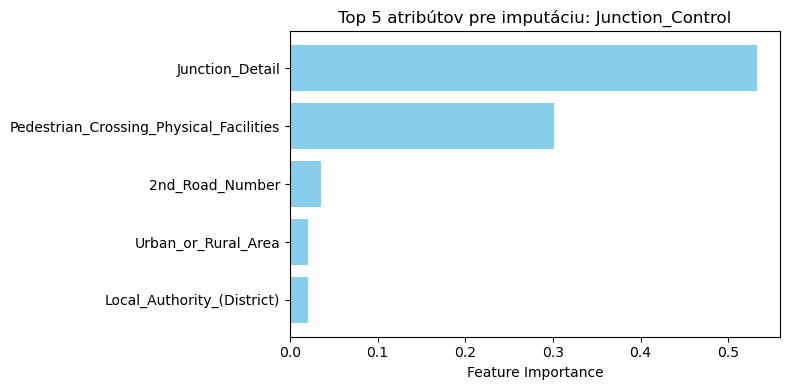


Imputácia pre atribút: 2nd_Road_Class


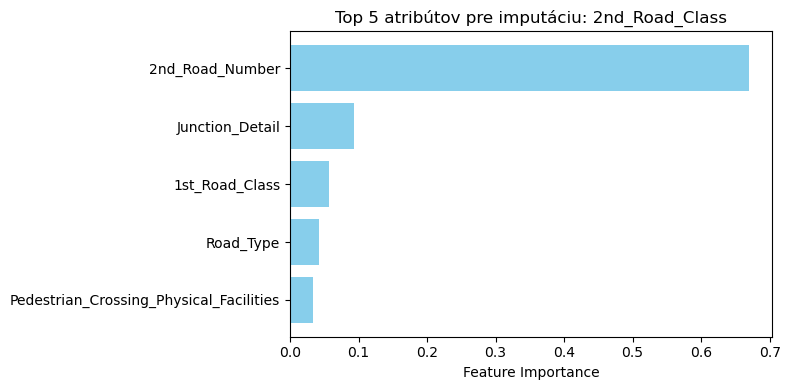


Log uložený do: /home/jovyan/work/TSVD_ZADANIE/imputation_feature_importance_log.csv


In [67]:
accidents = impute_categorical_with_model(
    accidents,
    ["Junction_Control", "2nd_Road_Class"],  # cieľové atribúty na imputáciu
    top_k_features=5  # Počet najlepších atribútov na trénovanie
)

In [68]:
count_negative(accidents, "Accidents")


Počet hodnôt = -1 v Accidents:

-RECORD 0------------------------------------------
 Location_Easting_OSGR                       | 0   
 Location_Northing_OSGR                      | 0   
 Longitude                                   | 0   
 Latitude                                    | 0   
 Police_Force                                | 0   
 Accident_Severity                           | 0   
 Number_of_Vehicles                          | 0   
 Number_of_Casualties                        | 0   
 Day_of_Week                                 | 0   
 Local_Authority_(District)                  | 0   
 1st_Road_Class                              | 0   
 1st_Road_Number                             | 0   
 Road_Type                                   | 0   
 Speed_limit                                 | 0   
 Junction_Detail                             | 0   
 Junction_Control                            | 0   
 2nd_Road_Class                              | 0   
 2nd_Road_Number               

In [69]:
count_negative(casualties, "Casualties")


Počet hodnôt = -1 v Casualties:

-RECORD 0-------------------------------------
 Vehicle_Reference                  | 0       
 Casualty_Reference                 | 0       
 Casualty_Class                     | 0       
 Sex_of_Casualty                    | 630     
 Age_of_Casualty                    | 0       
 Age_Band_of_Casualty               | 45920   
 Casualty_Severity                  | 0       
 Pedestrian_Location                | 12      
 Pedestrian_Movement                | 15      
 Car_Passenger                      | 404     
 Bus_or_Coach_Passenger             | 38      
 Pedestrian_Road_Maintenance_Worker | 1439022 
 Casualty_Type                      | 0       
 Casualty_Home_Area_Type            | 322715  



In [71]:
casualties_columns_to_check = ["Sex_of_Casualty",
                               "Pedestrian_Location",
                               "Pedestrian_Movement",
                               "Car_Passenger",
                               "Bus_or_Coach_Passenger"]

for col_name in casualties_columns_to_check:
    casualties = casualties.withColumn(col_name, col(col_name).cast(IntegerType()))

casualties_condition = reduce(lambda a, b: a & b, [col(c) != -1 for c in casualties_columns_to_check])
casualties = casualties.filter(casualties_condition)


Imputácia pre atribút: Age_Band_of_Casualty


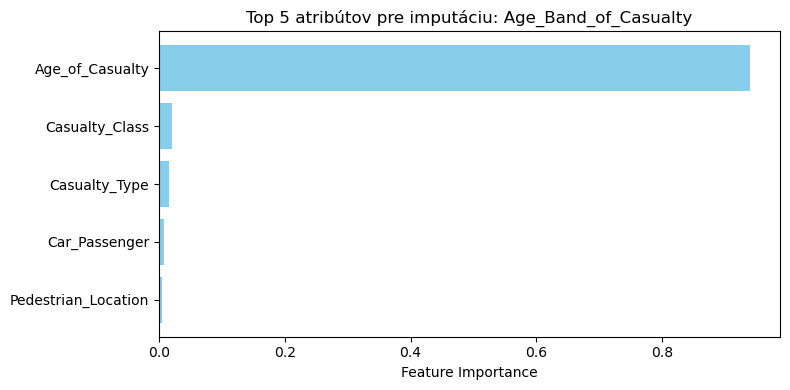


Imputácia pre atribút: Pedestrian_Road_Maintenance_Worker


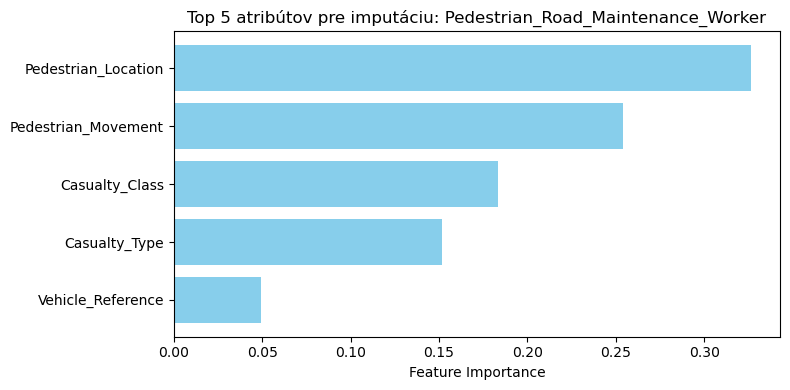


Imputácia pre atribút: Casualty_Home_Area_Type


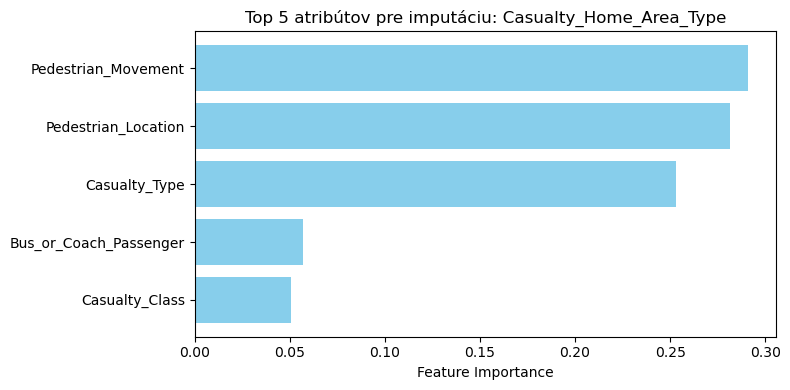


Log uložený do: /home/jovyan/work/TSVD_ZADANIE/imputation_feature_importance_log.csv


In [73]:
casualties = impute_categorical_with_model(
    casualties,
    ["Age_Band_of_Casualty", "Pedestrian_Road_Maintenance_Worker", "Casualty_Home_Area_Type"],  # cieľové atribúty na imputáciu
    top_k_features=5  # Počet najlepších atribútov na trénovanie
)

In [74]:
count_negative(casualties, "Casualties")


Počet hodnôt = -1 v Casualties:

-RECORD 0---------------------------------
 Vehicle_Reference                  | 0   
 Casualty_Reference                 | 0   
 Casualty_Class                     | 0   
 Sex_of_Casualty                    | 0   
 Age_of_Casualty                    | 0   
 Age_Band_of_Casualty               | 0   
 Casualty_Severity                  | 0   
 Pedestrian_Location                | 0   
 Pedestrian_Movement                | 0   
 Car_Passenger                      | 0   
 Bus_or_Coach_Passenger             | 0   
 Pedestrian_Road_Maintenance_Worker | 0   
 Casualty_Type                      | 0   
 Casualty_Home_Area_Type            | 0   



In [75]:
count_negative(vehicles, "Vehicles")


Počet hodnôt = -1 v Vehicles:

-RECORD 0----------------------------------
 Vehicle_Reference                | 0      
 Vehicle_Type                     | 473    
 Towing_and_Articulation          | 184    
 Vehicle_Manoeuvre                | 1080   
 Vehicle_Location_Restricted_Lane | 74     
 Junction_Location                | 9876   
 Skidding_and_Overturning         | 132    
 Hit_Object_in_Carriageway        | 87     
 Vehicle_Leaving_Carriageway      | 127    
 Hit_Object_off_Carriageway       | 54     
 1st_Point_of_Impact              | 565    
 Was_Vehicle_Left_Hand_Drive?     | 23049  
 Journey_Purpose_of_Driver        | 44921  
 Sex_of_Driver                    | 33     
 Age_of_Driver                    | 0      
 Age_Band_of_Driver               | 330608 
 Engine_Capacity_(CC)             | 0      
 Propulsion_Code                  | 770004 
 Age_of_Vehicle                   | 0      
 Driver_IMD_Decile                | 0      
 Driver_Home_Area_Type            | 588611 


In [80]:
vehicles_columns_to_check = ["Vehicle_Type",
                             "Towing_and_Articulation",
                             "Vehicle_Manoeuvre",
                             "Vehicle_Location_Restricted_Lane",
                             "Skidding_and_Overturning",
                             "Hit_Object_in_Carriageway",
                             "Vehicle_Leaving_Carriageway",
                             "Hit_Object_off_Carriageway",
                             "1st_Point_of_Impact",
                             "Sex_of_Driver",]

for col_name in vehicles_columns_to_check:
    vehicles = vehicles.withColumn(col_name, col(col_name).cast(IntegerType()))

vehicles_condition = reduce(lambda a, b: a & b, [col(c) != -1 for c in vehicles_columns_to_check])
vehicles = vehicles.filter(vehicles_condition)


Imputácia pre atribút: Junction_Location


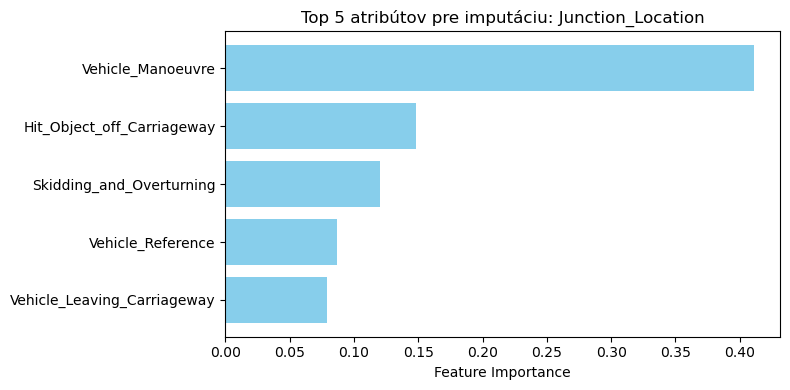


Imputácia pre atribút: Was_Vehicle_Left_Hand_Drive?


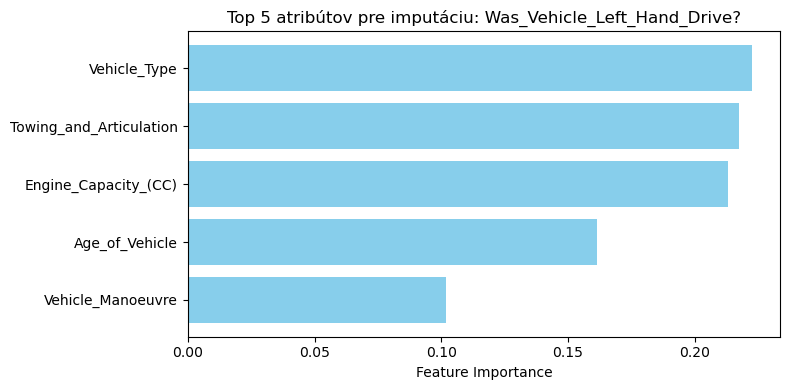


Imputácia pre atribút: Journey_Purpose_of_Driver


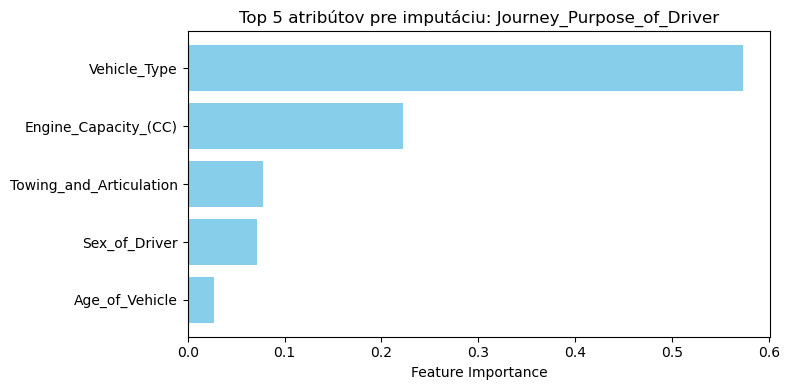


Imputácia pre atribút: Age_Band_of_Driver


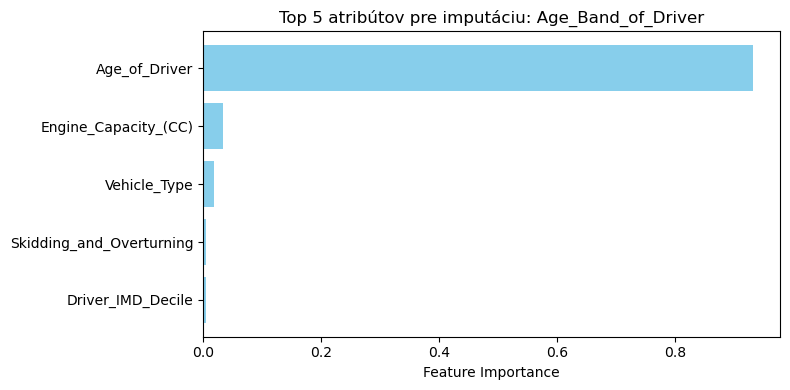


Imputácia pre atribút: Propulsion_Code


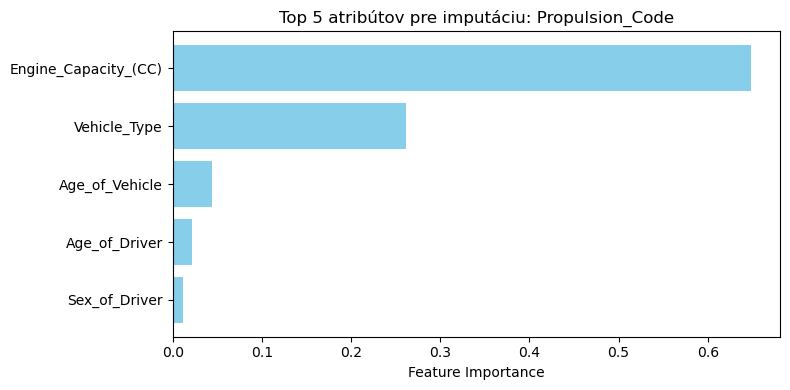


Imputácia pre atribút: Driver_Home_Area_Type


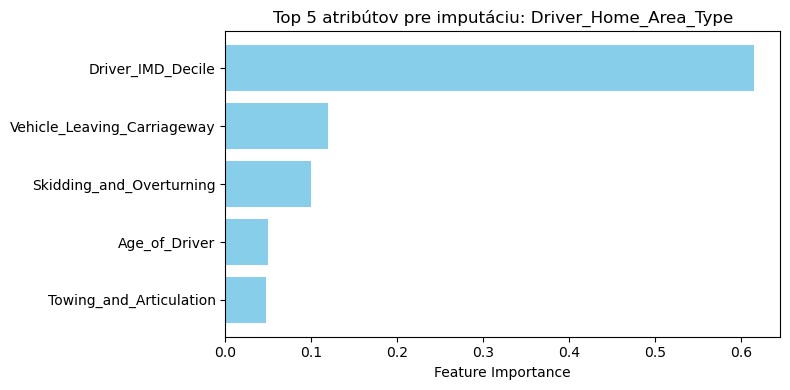


Log uložený do: /home/jovyan/work/TSVD_ZADANIE/imputation_feature_importance_log.csv


In [81]:
vehicles = impute_categorical_with_model(
    vehicles,
    ["Junction_Location", "Was_Vehicle_Left_Hand_Drive?", "Journey_Purpose_of_Driver","Age_Band_of_Driver","Propulsion_Code","Driver_Home_Area_Type"],  # cieľové atribúty na imputáciu
    top_k_features=5  # Počet najlepších atribútov na trénovanie
)

Uloženie datasetov očistených  -1 hodnoty

In [83]:
accidents.coalesce(1).write.option("header", True).mode("overwrite").csv("DATA/accidents_cleaned.csv")
casualties.coalesce(1).write.option("header", True).mode("overwrite").csv("DATA/casualties_cleaned.csv")
vehicles.coalesce(1).write.option("header", True).mode("overwrite").csv("DATA/vehicles_cleaned.csv")

Načítanie dát

In [86]:
accidents_cleaned = spark.read.csv("DATA/accidents_cleaned.csv/part-00000-f6e5e669-b78c-4237-aad1-504069a21772-c000.csv",header=True,inferSchema=True)
casualties_cleaned = spark.read.csv("DATA/casualties_cleaned.csv/part-00000-90efc901-58ae-4ba6-9fc9-59580029847b-c000.csv",header=True,inferSchema=True)
vehicles_cleaned = spark.read.csv("DATA/vehicles_cleaned.csv/part-00000-a88fe97c-bdab-4467-9ef4-ca8fdd45456b-c000.csv",header=True,inferSchema=True)

### Sú nejaké atribúty medzi datasetmi zhodné?

In [63]:
# Zistenie názvov atribútov
columns_accidents = set(accidents.columns)
columns_vehicles = set(vehicles.columns)
columns_casualties = set(casualties.columns)

# Zistenie, ktoré atribúty sú spoločné medzi dvoma datasetmi
common_vehicles_casualties = columns_vehicles & columns_casualties - columns_accidents
common_vehicles_accidents = columns_vehicles & columns_accidents - columns_casualties
common_casualties_accidnets = columns_casualties & columns_accidents - columns_vehicles

print("Spoločné iba pre vehicles a casualties:", common_vehicles_casualties)
print("Spoločné iba pre vehicles a accidents:", common_vehicles_accidents)
print("Spoločné iba pre casualties a accidents:", common_casualties_accidnets)

Spoločné iba pre vehicles a casualties: {'Vehicle_Reference'}
Spoločné iba pre vehicles a accidents: set()
Spoločné iba pre casualties a accidents: set()


### Zhodný atribút 'Vehicle_Reference' v datasetoch 'vehicles' a 'casualties'

In [26]:
# Zobrazenie ako často sa vyskytuje n konkrétnych hodnôt v datasete vehicles
# vehicles.groupBy("Vehicle_Reference").count().show(vertical=True,n=5)

In [27]:
# Zobrazenie ako často sa vyskytuje n konkrétnych hodnôt v datasete casualties
# casualties.groupBy("Vehicle_Reference").count().show(vertical=True,n=5)

In [64]:
unique_vehicles = vehicles.select("Vehicle_Reference").subtract(casualties.select("Vehicle_Reference"))
unique_casualties = casualties.select("Vehicle_Reference").subtract(vehicles.select("Vehicle_Reference"))

print("Je iba vo vehicles:")
unique_vehicles.show(vertical=True)

print("Je iba v casualties:")
unique_casualties.show(vertical=True)

Je iba vo vehicles:
-RECORD 0----------------
 Vehicle_Reference | 35  

Je iba v casualties:
(0 rows)



In [65]:
# Je niečo v casualties čo by vo vehicles nebolo (pre atribút Vehicle_Reference)?
# Ak áno, tak výsledok bude False, ak nie je, tak True a teda casualties.Vehicle_Reference je podmnožina vehicles.Vehicle_Reference
print(casualties.select("Vehicle_Reference").subtract(vehicles.select("Vehicle_Reference")).count() == 0)

True


In [66]:
# Záver: Vehicle_Reference vo vehicles obsahuje všetky možné hodnoty Vehicle_Reference z casualties
# Riešenie: Keďže vo vehicles existuje iba jedna hodnota "navyše", odstránime ju
vehicles = vehicles.filter(vehicles.Vehicle_Reference != 35)

In [67]:
# Overenie Vehicle_Reference
unique_vehicles = vehicles.select("Vehicle_Reference").subtract(casualties.select("Vehicle_Reference"))
unique_casualties = casualties.select("Vehicle_Reference").subtract(vehicles.select("Vehicle_Reference"))

print("Je iba vo vehicles:")
unique_vehicles.show(vertical=True)

print("Je iba v casualties:")
unique_casualties.show(vertical=True)

Je iba vo vehicles:
(0 rows)

Je iba v casualties:
(0 rows)



In [68]:
# Použitie aliasov pre oba datasety
vehicles_alias = vehicles.alias("vehicles")
casualties_alias = casualties.alias("casualties")

# Zlúčenie oboch datasetov s aliasami
comparison_df = vehicles_alias.join(casualties_alias, on="Accident_Index", how="left")

# Pridanie nového stĺpca pre porovnanie Vehicle_Reference medzi datasetmi
comparison_df = comparison_df.withColumn(
    "Vehicle_Reference_match",
    (F.col("vehicles.Vehicle_Reference") == F.col("casualties.Vehicle_Reference"))
)

# Zobraziť riadky, kde hodnoty nezhodujú
mismatched_df = comparison_df.filter(F.col("Vehicle_Reference_match") == False)

# Vypísať riadky s rozdielnymi hodnotami
mismatched_df.select("Accident_Index", "vehicles.Vehicle_Reference", "casualties.Vehicle_Reference").show(vertical=True,n=10)

-RECORD 0--------------------------
 Accident_Index    | 200501BS00003 
 Vehicle_Reference | 1             
 Vehicle_Reference | 2             
-RECORD 1--------------------------
 Accident_Index    | 200501BS00006 
 Vehicle_Reference | 1             
 Vehicle_Reference | 2             
-RECORD 2--------------------------
 Accident_Index    | 200501BS00007 
 Vehicle_Reference | 2             
 Vehicle_Reference | 1             
-RECORD 3--------------------------
 Accident_Index    | 200501BS00010 
 Vehicle_Reference | 1             
 Vehicle_Reference | 2             
-RECORD 4--------------------------
 Accident_Index    | 200501BS00010 
 Vehicle_Reference | 2             
 Vehicle_Reference | 1             
-RECORD 5--------------------------
 Accident_Index    | 200501BS00011 
 Vehicle_Reference | 2             
 Vehicle_Reference | 1             
-RECORD 6--------------------------
 Accident_Index    | 200501BS00011 
 Vehicle_Reference | 2             
 Vehicle_Reference | 1      

In [69]:
print(f"Počet rozdielnych záznamov: {mismatched_df.count()}\n\
Počet záznamov vo vehicles: {vehicles.count()}\n\
Počet záznamov v casualties: {casualties.count()}")

Počet rozdielnych záznamov: 2070803
Počet záznamov vo vehicles: 3004424
Počet záznamov v casualties: 2216720


In [70]:
# Treba sa rozodnúť, že z ktorého datasetu vyhodíme atribút Vehicle_Reference
# casualties = casualties.drop("Vehicle_Reference")
vehicles = vehicles.drop("Vehicle_Reference")

### Spojenie datasetov

In [71]:
datasets = {"Accidents": accidents, "Casualties": casualties, "Vehicles": vehicles}

for name, df in datasets.items():
    print(f"Počet atribútov v {name}: {len(df.columns)}")

Počet atribútov v Accidents: 32
Počet atribútov v Casualties: 15
Počet atribútov v Vehicles: 21


In [72]:
merged_df = accidents.join(casualties, on="Accident_Index", how="left") \
                     .join(vehicles, on="Accident_Index", how="left")

print(f"Počet atribútov v zlúčenom DataFrame: {len(merged_df.columns)}")

Počet atribútov v zlúčenom DataFrame: 66


In [73]:
# 32 + 15 + 22 = 69 => Záleží odkiaľ vyhodíme Vehicle_Reference
# 69 - 67 = tri datasety -> tri kľúče (atribút Accident_Index) a po spojení ostal len ako jeden atribút
# 67- 1 (Vehicle_reference z casualties)

### Kde všade (a koľko) sú null hodnoty po odstránení Vehicle_Reference a spojení datasetov?

In [74]:
null_counts = merged_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in merged_df.columns])
null_counts.show(vertical=True)

-RECORD 0---------------------------------------------
 Accident_Index                              | 0      
 Location_Easting_OSGR                       | 256    
 Location_Northing_OSGR                      | 256    
 Longitude                                   | 256    
 Latitude                                    | 256    
 Police_Force                                | 0      
 Accident_Severity                           | 0      
 Number_of_Vehicles                          | 0      
 Number_of_Casualties                        | 0      
 Date                                        | 0      
 Day_of_Week                                 | 0      
 Time                                        | 264    
 Local_Authority_(District)                  | 0      
 Local_Authority_(Highway)                   | 0      
 1st_Road_Class                              | 0      
 1st_Road_Number                             | 0      
 Road_Type                                   | 0      
 Speed_lim

In [76]:
# null hodnoty v atribúte LSOA_of_Accident_Location (v accidents)
# pred spojením datasetov
# LSOA_of_Accident_Location | 120574
# a po spojení do jedného datasetu
# LSOA_of_Accident_Location | 282711

In [77]:
missing_lsoa_df = merged_df.filter(F.col("LSOA_of_Accident_Location").isNull())
print(f"Počet nehôd bez LSOA_of_Accident_Location: {missing_lsoa_df.select('Accident_Index').distinct().count()}")

Počet nehôd bez LSOA_of_Accident_Location: 120574


In [79]:
missing_accidents = missing_lsoa_df.select("Accident_Index").distinct()
existing_in_accidents = missing_accidents.join(accidents, on="Accident_Index", how="left")

# Ak niektoré nehody majú NULL v stĺpci z accidents, znamená to, že neboli v pôvodnom datasets
existing_in_accidents.filter(F.col("LSOA_of_Accident_Location").isNull()).show(n=1, vertical=True)

-RECORD 0----------------------------------------------------------
 Accident_Index                              | 200501CP00089       
 Location_Easting_OSGR                       | 532820              
 Location_Northing_OSGR                      | 180570              
 Longitude                                   | -0.087512           
 Latitude                                    | 51.508404           
 Police_Force                                | 48                  
 Accident_Severity                           | 3                   
 Number_of_Vehicles                          | 1                   
 Number_of_Casualties                        | 1                   
 Date                                        | 15/04/2005          
 Day_of_Week                                 | 6                   
 Time                                        | 2025-04-04 16:50:00 
 Local_Authority_(District)                  | 570                 
 Local_Authority_(Highway)                   | E

In [86]:
# Okno pre každú nehodu (Accident_Index)
window_spec = Window.partitionBy("Accident_Index")

# Použitie prvej dostupnej hodnoty LSOA_of_Accident_Location v rámci každého Accident_Index
merged_df = merged_df.withColumn(
    "LSOA_of_Accident_Location",
    F.first("LSOA_of_Accident_Location", ignorenulls=True).over(window_spec)
)

In [87]:
merged_df.count()

4287523

In [85]:
merged_df.filter(F.col("LSOA_of_Accident_Location").isNull()).count()

282711

In [83]:
null_counts.show(vertical=True)

-RECORD 0---------------------------------------------
 Accident_Index                              | 0      
 Location_Easting_OSGR                       | 256    
 Location_Northing_OSGR                      | 256    
 Longitude                                   | 256    
 Latitude                                    | 256    
 Police_Force                                | 0      
 Accident_Severity                           | 0      
 Number_of_Vehicles                          | 0      
 Number_of_Casualties                        | 0      
 Date                                        | 0      
 Day_of_Week                                 | 0      
 Time                                        | 264    
 Local_Authority_(District)                  | 0      
 Local_Authority_(Highway)                   | 0      
 1st_Road_Class                              | 0      
 1st_Road_Number                             | 0      
 Road_Type                                   | 0      
 Speed_lim

1. Sampling a Rozdelenie na Tréningovaciu a Testovaciu Množinu
Najprv vytvoríme stratifikovanú vzorku (napr. 10 %) podľa cieľového atribútu. Predpokladáme, že cieľovým atribútom je napr. Accident_Severity (môžete upraviť podľa potreby). Potom vzorku rozdelíme na trénovaciu (60 %) a testovaciu (40 %).

In [17]:
# merged_df.select("Vehicle_Reference", "`Vehicles.Vehicle_Reference`", "`Casualties.Vehicle_Reference`").show(10)

In [18]:
# merged_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in merged_df.columns]).show(vertical=True)
# print(f"\n{30*'#'} KONIEC ANALÝZY {name} {30*'#'}\n")

In [47]:
# Zobrazenie počtu záznamov
# print("Celkový počet záznamov:", merged_df.count())

# Definujte hodnoty cieľového atribútu a nastavené fraction pre stratifikované sampling
# Napríklad, ak sú hodnoty 1, 2, 3 (kódovanie podľa závažnosti nehody)
target_col = "Accident_Severity"
fractions = {row[target_col]: 0.1 for row in merged_df.select(target_col).distinct().collect()}

# Stratifikované vzorkovanie
sample_df = merged_df.sampleBy(target_col, fractions, seed=42)
# print("Počet záznamov vo vzorke (10%):", sample_df.count())

# Rozdelenie vzorky na tréningovú a testovaciu množinu (60/40)
train_df, test_df = sample_df.randomSplit([0.6, 0.4], seed=42)
# print("Trénovacia množina:", train_df.count(), "záznamov")
# print("Testovacia množina:", test_df.count(), "záznamov")


Celkový počet záznamov: 4287593
Počet záznamov vo vzorke (10%): 429243
Tréningová množina: 257491 záznamov
Testovacia množina: 171191 záznamov


In [ ]:
# Celkový počet záznamov: 4287593
# Počet záznamov vo vzorke (10%): 42924
# Trénovacia množina: 257491 záznamov
# Testovacia množina: 171191 záznamov

2. Predspracovanie Dát
a) Transformácia nominálnych atribútov na numerické
Použijeme StringIndexer pre atribúty ako Accident_Severity a iné kategorizované stĺpce. Pre ilustráciu prevedieme cieľový atribút a jeden ďalší atribút (napr. Weather_Conditions).

In [13]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Bucketizer
from pyspark.ml import Pipeline

# StringIndexery pre kategóriové atribúty
severity_indexer = StringIndexer(inputCol="Accident_Severity", outputCol="Accident_Severity_Index", handleInvalid="keep")
weather_indexer = StringIndexer(inputCol="Weather_Conditions", outputCol="Weather_Conditions_Index", handleInvalid="keep")

# Prípadne môžeme použiť aj OneHotEncoder, ak budeme potrebovať one-hot reprezentáciu
weather_encoder = OneHotEncoder(inputCol="Weather_Conditions_Index", outputCol="Weather_Conditions_Encoded")

# Ako príklad budeme discretizovať aj numerický atribút, napr. 'Speed_limit'
# Definujte prahy pre Bucketizer – tieto hodnoty upravte podľa rozsahu v dátach
speed_splits = [0, 30, 50, 70, 100, float("Inf")]
speed_bucketizer = Bucketizer(splits=speed_splits, inputCol="Speed_limit", outputCol="Speed_limit_Bucket", handleInvalid="keep")

# Vytvorenie zoznamu vstupných atribútov pre klasifikačný model (príklad)
# Zvoľte atribúty, ktoré budú použité ako vstupy (toto je len ilustrácia – prispôsobte podľa analýzy)
feature_cols = ["Number_of_Vehicles", "Number_of_Casualties", "Speed_limit_Bucket", "Weather_Conditions_Index"]

# Pre zostavenie feature vektora
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="keep")

# Zostavenie Pipeline pre predspracovanie
preprocessing_pipeline = Pipeline(stages=[
    severity_indexer,
    weather_indexer,
    weather_encoder,
    speed_bucketizer,
    assembler
])
preprocessed_model = preprocessing_pipeline.fit(train_df)
train_preprocessed = preprocessed_model.transform(train_df)
test_preprocessed = preprocessed_model.transform(test_df)

# Overenie výsledkov
train_preprocessed.select("Accident_Severity", "Accident_Severity_Index", "Speed_limit", "Speed_limit_Bucket", "features").show(3, truncate=False)


+-----------------+-----------------------+-----------+------------------+-----------------+
|Accident_Severity|Accident_Severity_Index|Speed_limit|Speed_limit_Bucket|features         |
+-----------------+-----------------------+-----------+------------------+-----------------+
|3                |0.0                    |30         |1.0               |[2.0,1.0,1.0,0.0]|
|2                |1.0                    |30         |1.0               |[2.0,1.0,1.0,0.0]|
|3                |0.0                    |30         |1.0               |[2.0,1.0,1.0,1.0]|
+-----------------+-----------------------+-----------+------------------+-----------------+
only showing top 3 rows



b) Spracovanie chýbajúcich hodnôt
Ukážeme, ako nahradiť chýbajúce hodnoty, pričom hodnoty "-1" považujeme za neplatné. Tu je príklad pre jeden numerický atribút. Môžete tento prístup aplikovať na viacero stĺpcov.

In [14]:
from pyspark.sql.functions import when, avg

# Príklad: Nahradenie neplatných hodnôt v stĺpci 'Speed_limit'
# Najprv prepočítame priemer, pričom vynecháme hodnoty -1
mean_speed = merged_df.filter(merged_df["Speed_limit"] != -1).select(avg("Speed_limit")).first()[0]
print("Priemerná hodnota Speed_limit:", mean_speed)

# Vytvorenie DataFrame, kde nahradíme -1 priemerom
merged_df_clean = merged_df.withColumn("Speed_limit_clean",
                                       when(col("Speed_limit") == -1, mean_speed)
                                       .otherwise(col("Speed_limit")))
merged_df_clean.select("Speed_limit", "Speed_limit_clean").show(3)


Priemerná hodnota Speed_limit: 41.10451831598755
+-----------+-----------------+
|Speed_limit|Speed_limit_clean|
+-----------+-----------------+
|         30|             30.0|
|         30|             30.0|
|         30|             30.0|
+-----------+-----------------+
only showing top 3 rows



Pre kategóriové atribúty by ste mohli zvoliť najčastejšiu hodnotu (mode). Rovnaký prístup potom opakujte pre ostatné relevantné atribúty.

c) Výpočet informačného zisku pre nominálne atribúty
Jednoduchý spôsob je použiť vstavané metódy modelov (napr. Decision Tree), ktoré dokážu poskytnúť dôležitosť atribútov. 
Ak však potrebujete explicitne vypočítať informačný zisk, môžete si vytvoriť vlastnú funkciu. Tu je ilustratívny príklad 
pre jeden atribút:

import math
from pyspark.sql import functions as F

def compute_entropy(df, col_name):
    # Počet celkových záznamov
    total = df.count()
    # Počet výskytov jednotlivých kategórií
    counts = df.groupBy(col_name).count().collect()
    entropy = 0.0
    for row in counts:
        p = row["count"] / total
        entropy -= p * math.log(p, 2)
    return entropy

# Výpočet entropie cieľového atribútu
entropy_target = compute_entropy(train_df, "Accident_Severity")
print("Entropia cieľového atribútu (Accident_Severity):", entropy_target)

# Pre výpočet informačného zisku pre atribút napr. 'Weather_Conditions'
entropy_weather = compute_entropy(train_df, "Weather_Conditions")

# Spočítanie podmienenej entropie
# Rozdelenie podľa 'Weather_Conditions' a výpočet entropie v každej skupine
group_entropy = train_df.groupBy("Weather_Conditions").agg(F.count("*").alias("cnt")).collect()
weighted_entropy = 0.0
total = train_df.count()
for row in group_entropy:
    p = row["cnt"] / total
    sub_df = train_df.filter(train_df["Weather_Conditions"] == row["Weather_Conditions"])
    weighted_entropy += p * compute_entropy(sub_df, "Accident_Severity")

information_gain = entropy_target - weighted_entropy
print("Informačný zisk pre Weather_Conditions:", information_gain)


3. Modelovanie
a) K-means Clustering a Detekcia Anomálií
Najprv vytvoríme K-means model s predspracovanými dátami a následne zistíme anomálie podľa vzdialenosti od centroidu.

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Použijeme pre clustering atribút 'features' vytvorený v pipeline
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=5, seed=42)
kmeans_model = kmeans.fit(train_preprocessed)

# Pridanie clusterov pre tréningovú množinu
train_clustered = kmeans_model.transform(train_preprocessed)
train_clustered.select("features", "cluster").show(3)

# Vyhodnotenie clusteringu (napr. pomocou silhouette score)
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(train_clustered)
print("Silhouette score:", silhouette)

# Detekcia anomálií:
# Vypočítame vzdialenosť každého bodu od príslušného centroidu
centers = kmeans_model.clusterCenters()
def compute_distance(features, center):
    return float(features.squared_distance(center))  # Funkcia squared_distance nie je priamo dostupná; budeme pracovať pomocou operácií

# Pre ilustráciu využijeme User Defined Function (UDF) pre výpočet Euklidovskej vzdialenosti
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import numpy as np

def euclidean_distance(v, center):
    return float(np.sqrt(np.sum((np.array(v) - np.array(center))**2)))

# UDF: pre každý riadok vypočíta vzdialenosť od príslušného centroidu
def distance_from_center(features, cluster):
    center = centers[int(cluster)]
    return euclidean_distance(features, center)

distance_udf = udf(distance_from_center, DoubleType())
train_clustered = train_clustered.withColumn("distance", distance_udf(col("features"), col("cluster")))
train_clustered.select("cluster", "distance").show(3)

# Označenie anomálií: napr. tie záznamy, ktorých vzdialenosť presahuje prah – tento prah môžete nastaviť napr. ako percentil vzdialeností
distances = train_clustered.select("distance").rdd.flatMap(lambda x: x).collect()
threshold = np.percentile(distances, 95)  # 95. percentil
print("Prahová hodnota pre anomáliu (95. percentil):", threshold)

anomalies = train_clustered.filter(col("distance") > threshold)
print("Počet detekovaných anomálií:", anomalies.count())


b) Klasifikačné Modely
V nasledujúcom bloku vytvoríme viacero klasifikačných modelov pomocou pipeline – Decision Tree, Linear SVM, Naive Bayes a Random Forest. Ako príklad využijeme už vytvorený pipeline pre predspracovanie. Cieľovým atribútom je Accident_Severity_Index.

In [15]:
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Príprava dát už máme v train_preprocessed a test_preprocessed
# Použijeme "features" a "Accident_Severity_Index" ako target

# 1. Decision Tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Accident_Severity_Index", seed=42)
dt_model = dt.fit(train_preprocessed)
dt_predictions = dt_model.transform(test_preprocessed)

# 2. Linear SVM
# Upozornenie: LinearSVC vyžaduje, aby cieľové hodnoty boli indexované a v tvare Double
svm = LinearSVC(featuresCol="features", labelCol="Accident_Severity_Index", maxIter=10, regParam=0.1)
svm_model = svm.fit(train_preprocessed)
svm_predictions = svm_model.transform(test_preprocessed)

# 3. Naive Bayes
nb = NaiveBayes(featuresCol="features", labelCol="Accident_Severity_Index", modelType="multinomial")
nb_model = nb.fit(train_preprocessed)
nb_predictions = nb_model.transform(test_preprocessed)

# 4. Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="Accident_Severity_Index", numTrees=20, seed=42)
rf_model = rf.fit(train_preprocessed)
rf_predictions = rf_model.transform(test_preprocessed)

# Funkcia na vyhodnotenie modelu
def evaluate_model(predictions, model_name="Model"):
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="Accident_Severity_Index", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Accident_Severity_Index", predictionCol="prediction", metricName="f1")
    accuracy = evaluator_acc.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")
    
    # Kontingenčná tabuľka (confusion matrix)
    predictions.groupBy("Accident_Severity_Index", "prediction").count().orderBy("Accident_Severity_Index", "prediction").show()

print("\nVyhodnotenie Decision Tree:")
evaluate_model(dt_predictions, "Decision Tree")

print("\nVyhodnotenie Linear SVM:")
evaluate_model(svm_predictions, "Linear SVM")

print("\nVyhodnotenie Naive Bayes:")
evaluate_model(nb_predictions, "Naive Bayes")

print("\nVyhodnotenie Random Forest:")
evaluate_model(rf_predictions, "Random Forest")


SparkRuntimeException: [USER_RAISED_EXCEPTION] Labels MUST be in {0, 1}, but got 2.0 SQLSTATE: P0001

4. Výpočet Ďalších Metrík
Pre MCC (Matthews Correlation Coefficient) a ďalšie metriky je možné vypočítať manuálne na základe confusion matrix. Tu je jednoduchý príklad pre binárny prípad; pre viactriedne problémy by bolo potrebné rozšíriť výpočet.

In [16]:
import numpy as np
import pandas as pd

# Funkcia pre výpočet MCC z confusion matrix pre binárny prípad
def compute_mcc(confusion_pd):
    # Predpokladáme, že confusion_pd má stĺpce: label, prediction, count
    # Najprv extrahujeme TP, TN, FP, FN – toto funguje len pre binárnu klasifikáciu
    # Upravte podľa potreby pre viac tried
    tp = confusion_pd[(confusion_pd['label'] == 1) & (confusion_pd['prediction'] == 1)]['count'].sum()
    tn = confusion_pd[(confusion_pd['label'] == 0) & (confusion_pd['prediction'] == 0)]['count'].sum()
    fp = confusion_pd[(confusion_pd['label'] == 0) & (confusion_pd['prediction'] == 1)]['count'].sum()
    fn = confusion_pd[(confusion_pd['label'] == 1) & (confusion_pd['prediction'] == 0)]['count'].sum()
    numerator = tp * tn - fp * fn
    denominator = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if denominator == 0:
        return 0
    return numerator/denominator

# Príklad pre Decision Tree (ak máte binárnu klasifikáciu)
dt_conf_df = dt_predictions.groupBy("Accident_Severity_Index", "prediction").count().toPandas()
print("Confusion matrix (Decision Tree):")
print(dt_conf_df)
# Ak je to viactriedna klasifikácia, MCC sa zvyčajne počíta inak.
# print("MCC (Decision Tree):", compute_mcc(dt_conf_df))


Confusion matrix (Decision Tree):
   Accident_Severity_Index  prediction   count
0                      2.0         0.0    3162
1                      1.0         1.0     413
2                      0.0         1.0      84
3                      1.0         0.0   23593
4                      2.0         1.0      73
5                      0.0         0.0  143790
6                      0.0         2.0       6
7                      2.0         2.0      70


Zhrnutie
Tento návrh kódu rozširuje Váš pôvodný .ipynb súbor o:

Stratifikované sampling a rozdelenie dát.

Predspracovanie (transformácia kategórií, discretizácia numerických atribútov, nahradenie chýbajúcich hodnôt).

Výpočet informačného zisku pre vybraný atribút.

Vytvorenie K-means modelu a jednoduchú detekciu anomálií.

Viaceré klasifikačné modely (Decision Tree, Linear SVM, Naive Bayes, Random Forest) a ich vyhodnotenie pomocou confusion matrix a základných metrík.

Ak by ste chceli prebrať konkrétnu časť podrobnejšie alebo upraviť niektoré kroky, dajte vedieť, rád pomôžem ďalej.